# Evaluation of GPROF precipitation estimates

This notebooks demonstrates how to use the ``satrain.evaluation.Evaluator`` class to evaluate GPROF V7 retrievals. Since the evaluation of GPROF retrievals is largely similar to the evaluation of the IMERG retrievals, this example will not explain all the configuration details. For a more thorough introduction to using the ``Evaluator`` class, refer to [the IMERG example](evaluat_imerge.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from typing import Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# A retrieval callback function for GPROF retrievals

To evaluate GPROF retrievals with the Evaluator class, a retrieval callback function is required. This function returns GPROF retrieval results for each of the collocation scenes in the SPR evaluation dataset. Since the scenes in the SPR dataset for GMI correspond to GMI overpasses over the MRMS domain, they map directly to GPROF result files. The ``input_data`` dataset that the evaluator passes to the retrieval callback function includes the name of the GPM L1C file from which the collocation was created as well as the scan range. This structure makes it straightforward to load the corresponding results from the GPROF L2A file with the matching granule number.

## Helper functions

To simplify the loading of the GPROF results, we index the locally available files by their granule number. The code below builds a dictionary mapping the granule numbers to corresponding GPROF L2A files. This dictionary will enable efficient retrieval of GPROF files for the retrieval input data provided by the ``satrain`` evaluator.

To streamline loading GPROF results, the code below indexes locally available files by their granule number by building a dictionary mapping granule numbers to corresponding GPROF L2A files. This dictionary allows efficient retrieval of GPROF files for the input data provided by the evaluator.

In [29]:
def get_granule(path: Path) -> int:
    """
    Extract granule number from GPROF file name.

    Args:
        path: A Path object pointing to a GPROF L2A file.

    Return:
        The granule number as an integer.
    """
    # GPROF filename example: 2A.GPM.GMI.GPROF2021v1.20200630-S225114-E002346.036018.V07A.HDF5
    path = Path(path)
    parts = path.name.split('.')
    granule = int(parts[-3])
    return granule

GPROF_DATA_PATH = "/data/satellite_data/gpm/2a/gpm/gmi/"
gprof_files = Path(GPROF_DATA_PATH).glob("*.HDF5")
gprof_files = {
    get_granule(path): path for path in gprof_files
}

Next we define a function to load the retrieval results from a given GPROF file and scan range. Since GPROF provides quantitative precipitation estimates as well as a probability of precipitation and a precipitation yes/no flag, the function returns these as an ``xarray.Dataset`` using the variable names expected by the evaluator. 

To asses the ability of GPROF to detect heavy precipitation, we also define a ``heavy_precip_flag`` that is set to ``True`` when the retrived precipitation exceeds 10 mm h$^{-1}$. Moreover, we define an ad-hoc probability of heavy precipitation by normalizing the retrieved surface precipitation by 100.0 and clipping the values to the range $[0, 1]$.

In [3]:
def load_gprof_precip(path: Path, scan_start: int, scan_end: int) -> xr.Dataset:
    """
    Load GPROF precipitation.

    Args:
        path: A Path object pointing to the IMERG file to load.
        scan_start: The start scan of the collocation.
        scan_end: Index pointing to the first scan that is not part of 
             the collocation anymore.

    Return:
        An xarray.Dataset containing the 'surface_precip', 'probability_of_precip',
        'precipitation_flag', 'probability_of_heavy_precip', and 'heavy_precip_flag'
        extracted from the GPROF file pointed to by 'path'.
    """
    slc = slice(scan_start, scan_end)
    with h5py.File(path) as data:
        lons = data["S1/Latitude"][slc]
        lats = data["S1/Longitude"][slc]
        
        surface_precip = data["S1/surfacePrecipitation"][slc]
        invalid = surface_precip < 0
        surface_precip[invalid] = np.nan
        probability_of_precip = data["S1/probabilityOfPrecip"][slc] / 100.0
        precipitation_flag = data["S1/precipitationYesNoFlag"][slc]
        probability_of_heavy_precip = np.clip(surface_precip / 100, 0.0, 1.0)
        
    return xr.Dataset({
        "longitude": (("scan", "pixel"), lons),
        "latitude": (("scan", "pixel"), lats),
        "surface_precip": (("scan", "pixel"), surface_precip),
        "probability_of_precip": (("scan", "pixel"), probability_of_precip),
        "precip_flag": (("scan", "pixel"), precipitation_flag),
        "probability_of_heavy_precip": (("scan", "pixel"), probability_of_heavy_precip),
        "heavy_precip_flag": (("scan", "pixel"), surface_precip > 10),
    })


## The retrieval callback

With the helper functions in place, it is easy to to implement a retrieval callback function. The function extracts the granule number and scan range from the attributes of the ``input_data`` dataset and then uses the two helper functions above to load the corresponding data from the GPROF file. Note that the evaluator will take care of mapping the swath-based estimates from GPROF to the regular latitude-longitude grid used for the SPR dataset.

In [ ]:
def retrieve_gprof(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval callback function to load GPROF data corresponding to SATRAIN SPR evaluation data.

    Args:
        input_data: An xarray.Dataset containing the retrieval input data.

    Return:
        An xarray.Dataset containing the retrieval results.
    """
    input_file = input_data.attrs["gpm_input_file"]
    scan_start = input_data.attrs["scan_start"]
    scan_end = input_data.attrs["scan_end"]
    granule = get_granule(input_file)
    gprof_file = gprof_files[granule]
    return load_gprof_precip(gprof_file, scan_start, scan_end)

# Evaluating GPROF retrievals

For the evaluation of the GPROF retrievals we instantiate the evaluator with the ``on_swath`` geometry because the GPROF V7 results are provided at the nominal GMI footprint positions. The evaluator will then automatically map these results to the nearest gridded MRMS measurements.

In [27]:
from pathlib import Path

from ipwgml.evaluation import Evaluator
from ipwgml.target import TargetConfig

geometry = "native"
evaluator = Evaluator(
    domain="conus",
    base_sensor="gmi",
    geometry="on_swath",
    target_config=TargetConfig(min_rqi=0.5),
    retrieval_input=["gmi", "ancillary"],
    download=True
)
print(f"Found {len(evaluator)} overpasses.")

Output()

Output()

Found 2912 overpasses.


## Case study

To verify the implementation of the ``retrieval_fn`` callback, we display the results for a single scene using the evaluator's ``plot_retrieval_results`` function.

/home/simon/miniconda3/envs/ipwgml/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


160500


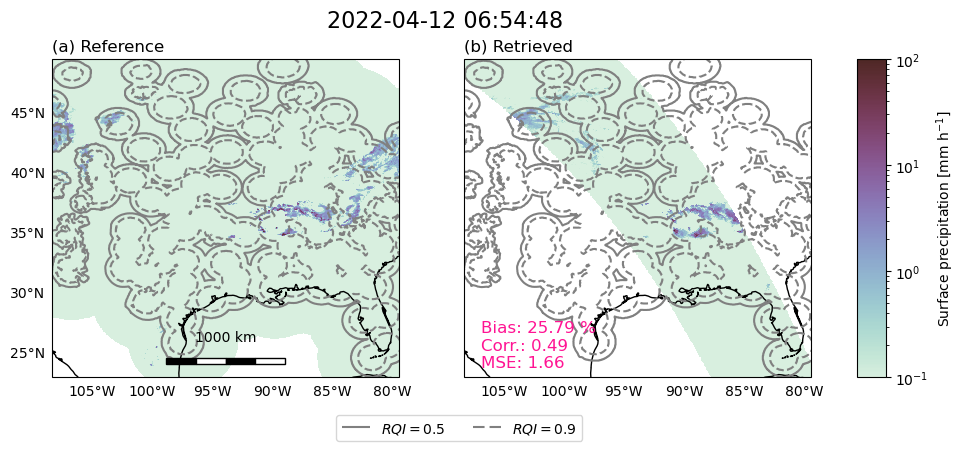

In [43]:
fig = evaluator.plot_retrieval_results(800, retrieval_fn=retrieve_gprof, include_metrics=True)

## Running the evaluator

We use the ``n_processes`` argument to run the evaluation using multiple processes in parallel.

In [35]:
evaluator.evaluate(retrieve_gprof, n_processes=8)

Output()

### Precipitation quantification

In [36]:
evaluator.get_precip_quantification_results(name="GPROF V7 (GMI)", include_baselines=False)

,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
GPROF V7 (GMI),-0.334747,0.10781,0.81608,100.312201,0.545665,0.577593


### Precipitation detection

In [37]:
evaluator.get_precip_detection_results(name="GPROF V7 (GMI)", include_baselines=False)

,POD [],FAR [],HSS []
GPROF V7 (GMI),0.637779,0.65736,0.250394


### Probabilistic precipitation detection

In [38]:
evaluator.get_prob_precip_detection_results(name="GPROF V7 (GMI)", include_baselines=False)

,AUC []
GPROF V7 (GMI),0.511321


### Heavy precipitation detection

In [39]:
evaluator.get_heavy_precip_detection_results(name="GPROF V7 (GMI)", include_baselines=False)

,POD [],FAR [],HSS []
GPROF V7 (GMI),0.185042,0.573519,0.426159


### Heavy probabilistic precipitation detection

In [40]:
evaluator.get_prob_heavy_precip_detection_results(name="GPROF V7 (GMI)", include_baselines=False)

,AUC []
GPROF V7 (GMI),0.237847
